In [34]:
# imports 
import pandas as pd
import numpy as np
from Survival_prob_Class import survival_prob
import matplotlib.pyplot as plt

In [20]:
# initialize simulation 
surv_prob = survival_prob()

In [21]:
# read the simulation datasets 
sim_05_1 = pd.read_csv('Data/simulation_half_1st.csv')
sim_05_2 = pd.read_csv('Data/simulation_half_2nd.csv')
sim_05_3 = pd.read_csv('Data/simulation_half_3rd.csv')
sim_1_1 = pd.read_csv('Data/simulation_one_1st.csv')
sim_1_2 = pd.read_csv('Data/simulation_one_2nd.csv')
sim_1_3 = pd.read_csv('Data/simulation_one_3rd.csv')
real_vector = pd.read_csv('Data/interventions.csv')

In [22]:
# concatenate the three simulation datasets per percentage 
# 0.5%
sim_05 = pd.concat([sim_05_1, sim_05_2, sim_05_3])
# reset index 
sim_05 = sim_05.reset_index(drop=True)
# 1% 
sim_1 = pd.concat([sim_1_1, sim_1_2, sim_1_3])
# reset index 
sim_1 = sim_1.reset_index(drop=True)

In [23]:
# remove unecessary columns, only need duration_Responder, duration_AED and duration_Vector 
# columns to drop
columns_to_drop = ['Patient_loc', 'Responder_lon', 'Responder_lat', 'AED_lon', 'AED_lat', 'Vector_lon', 'Vector_lat']  
sim_05.drop(columns=columns_to_drop, inplace=True)
sim_1.drop(columns=columns_to_drop, inplace=True)

In [24]:
real_vector

,T1,T3,Latitude intervention,Longitude intervention,Response Time
0,2022-06-07 07:02:17,2022-06-07 07:11:24,50.861866,4.708210,547.0
1,2022-06-08 13:26:34,2022-06-08 13:35:03,50.873174,4.716699,509.0
2,2022-06-08 14:35:19,2022-06-08 14:47:58,50.928140,4.703247,759.0
3,2022-06-09 09:51:23,2022-06-09 10:03:05,50.874550,4.730246,702.0
4,2022-06-13 12:35:22,2022-06-13 12:44:12,50.879098,4.696672,530.0
...,...,...,...,...,...
76,2023-04-27 09:45:18,2023-04-27 09:54:43,50.856571,4.653801,565.0
77,2023-05-02 18:36:37,2023-05-02 18:45:01,50.858510,4.693520,504.0
78,2023-05-03 17:38:46,2023-05-03 17:46:05,50.861650,4.681370,439.0
79,2023-05-13 11:26:53,2023-05-13 11:50:12,50.885531,4.684591,1399.0


In [25]:
#add the real vector times to the dataframes 
sim_05['real_duration_Vector'] = real_vector['Response Time']
sim_1['real_duration_Vector'] = real_vector['Response Time']

In [26]:
# calculate time for the slowest vector 
np.max(sim_1['duration_Vector'])
np.max(sim_1['real_duration_Vector'])

2010.0

In [27]:
# in some cases the AED never arrives (it is too far away), need to put this to a value for Survival_prob_Class.py
# choose a very large value (10 000) then we know that the vector always will be faster, slowest vector 703.8 s 

# find instances where duration_AED is 'No AED' and replace them with 10000
sim_05['duration_AED'] = sim_05['duration_AED'].replace('No AED', float(10000))
sim_1['duration_AED'] = sim_1['duration_AED'].replace('No AED', float(10000))


In [28]:
# in the case we don't have a responder, too far away from the patient
# put time of patient to something very large -> same probability of survival with and without fcr, what we would have with only vector

# find instances where duration_Respinder is 'No responder' and replace them with 10000
sim_05['duration_Responder'] = sim_05['duration_Responder'].replace('No responder', float(10000))
sim_1['duration_Responder'] = sim_1['duration_Responder'].replace('No responder', float(10000))

In [29]:
# estimate probability of survival

# save probabilites in df
df_prob_05 = pd.DataFrame(columns=['prob_resp', 'prob_vec'])
df_prob_1 = pd.DataFrame(columns=['prob_resp', 'prob_vec'])

# loop through df 0.5, use simulated vector times 
for index, row in sim_05.iterrows():
    prob_resp, prob_vec = surv_prob.probability_survival(float(row['duration_Responder']), float(row['duration_AED']), row['duration_Vector'])
    # add calcualted probabilities to df 
    df_prob_05.loc[index] = {'prob_resp': prob_resp, 'prob_vec': prob_vec}

# loop through df 1, use real vector times 
for index, row in sim_1.iterrows():
    prob_resp, prob_vec = surv_prob.probability_survival(float(row['duration_Responder']), float(row['duration_AED']), row['real_duration_Vector'])
    # add calcualted probabilities to df 
    df_prob_1.loc[index] = {'prob_resp': prob_resp, 'prob_vec': prob_vec}

### Plot the suvival probabilities

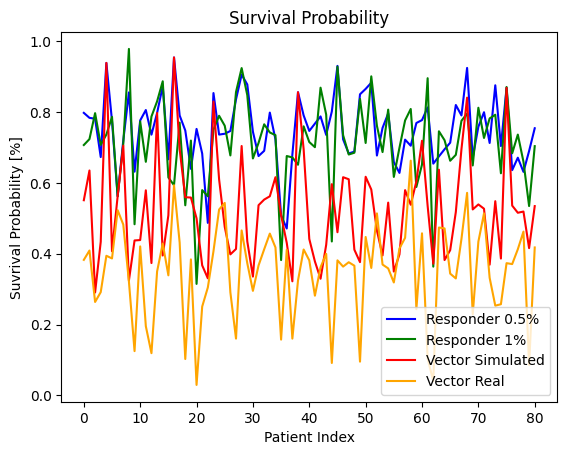

In [31]:
# plot the survival probability of fcr and vector for different percentages 
# plt.figure(figsize=(10, 6))
plt.plot(df_prob_05.index, df_prob_05['prob_resp'], label='Responder 0.5%', c='blue')
plt.plot(df_prob_1.index, df_prob_1['prob_resp'], label='Responder 1%', c='green')
plt.plot(df_prob_05.index, df_prob_05['prob_vec'], label='Vector Simulated', c='red')
plt.plot(df_prob_1.index, df_prob_1['prob_vec'], label='Vector Real', c='orange')

plt.xlabel('Patient Index')
plt.ylabel('Suvrival Probability [%]')
plt.title('Survival Probability')
plt.legend()
plt.show()

In [33]:
# calculate the mean survival probability 
print('Mean survival probability FCR 0.5%:')
print(np.mean(df_prob_05['prob_resp']))
print('Mean survival probability FCR 1.0%:')
print(np.mean(df_prob_1['prob_resp']))
print('Mean survival probability vector simulated:')
print(np.mean(df_prob_05['prob_vec']))
print('Mean survival probability vector real:')
print(np.mean(df_prob_1['prob_vec']))

Mean survival probability FCR 0.5%:
0.749377634347836
Mean survival probability FCR 1.0%:
0.7138813574017974
Mean survival probability vector simulated:
0.5277901935644382
Mean survival probability vector real:
0.3496460336047981
